# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

import scipy.constants
from scipy.sparse import csgraph

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

from tqdm import tqdm, trange

import itertools
import math

from tabulate import tabulate

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [2]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
F_D_MAX = 2*N_MAX + I1_D + I2_D
print(f"{N_STATES} states loaded from molecule.")

GAUSS = 1e-4 # T

Rb87Cs133NMax2
288 states loaded from molecule.


# Load precomputed results

In [3]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

LABELS_D=data['labels_d']
LABELS_DEGENERACY = data['labels_degeneracy']
STATE_JUMP_LIST = data['state_jump_list']

TRANSITION_LABELS_D = data['transition_labels_d']
TRANSITION_INDICES = data['transition_indices']
EDGE_JUMP_LIST = data['edge_jump_list']


MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_SPARSE=data['couplings_sparse']
TRANSITION_GATE_TIMES_POL = data['transition_gate_times_pol']
TRANSITION_GATE_TIMES_UNPOL = data['transition_gate_times_unpol']

CUMULATIVE_TIME_FROM_INITIALS_POL = data['cumulative_pol_time_from_initials']
PREDECESSOR_POL = data['predecessor_pol_time_from_initials']

CUMULATIVE_TIME_FROM_INITIALS_UNPOL = data['cumulative_unpol_time_from_initials']
PREDECESSOR_UNPOL = data['predecessor_unpol_time_from_initials']

def label_degeneracy(N,MF_D):
    return LABELS_DEGENERACY[N,(MF_D+F_D_MAX)//2]

def label_d_to_node_index(N,MF_D,d):
    return STATE_JUMP_LIST[N,(MF_D+F_D_MAX)//2]+d

def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return EDGE_JUMP_LIST[label_d_to_node_index(N,MF_D,d)]

INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = [label_d_to_node_index(*label_d) for label_d in INITIAL_STATE_LABELS_D]
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)
print("Loaded precomputed data.")

Loading precomputed data...
Loaded precomputed data.


In [4]:
MAGNETIC_MOMENTS.shape

(288, 1449)

# Helper Functions

In [5]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)
    
def fid_to_string(fid):
    return f"{fid:.4f}({fidelity(fid,d=9):.1f})"

In [6]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [7]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [8]:
def label_pair_to_edge_index(label1,label2):
    first_indices = label_d_to_edge_indices(*label1)
    section = 3*((label2[0] - label1[0]) < 0) + [0,1,2][(label2[0] - label1[0])*(label1[1] - label2[1])//2]
    return first_indices[section]+label2[2]

TRANSITION_LABELS_D[label_pair_to_edge_index((1,4,3),(0,2,1))]

array([1, 4, 3, 0, 2, 1])

# Zeeman Plot

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


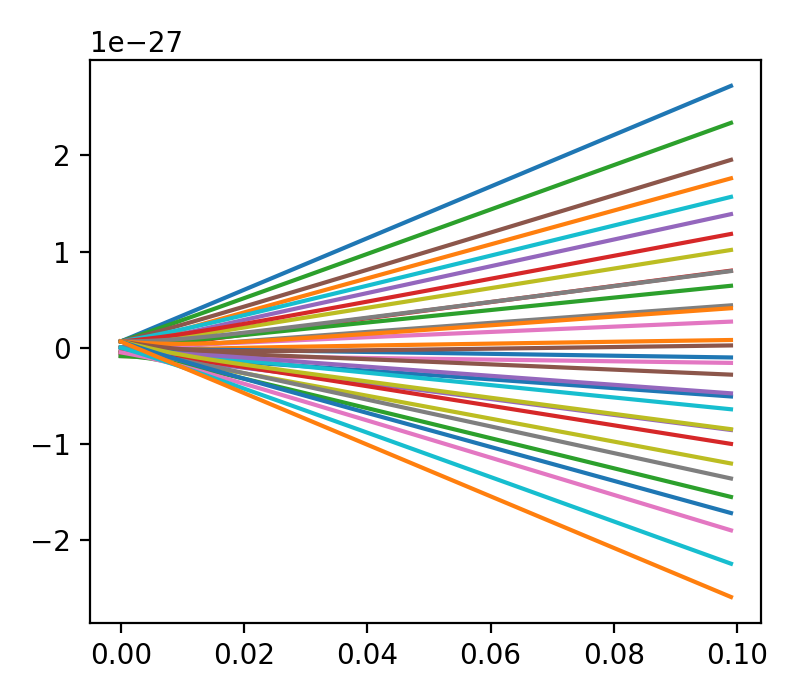

In [9]:
fig,ax = plt.subplots()
ax.plot(B,ENERGIES[0:32,:].T)

plotting zeeman diagram...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


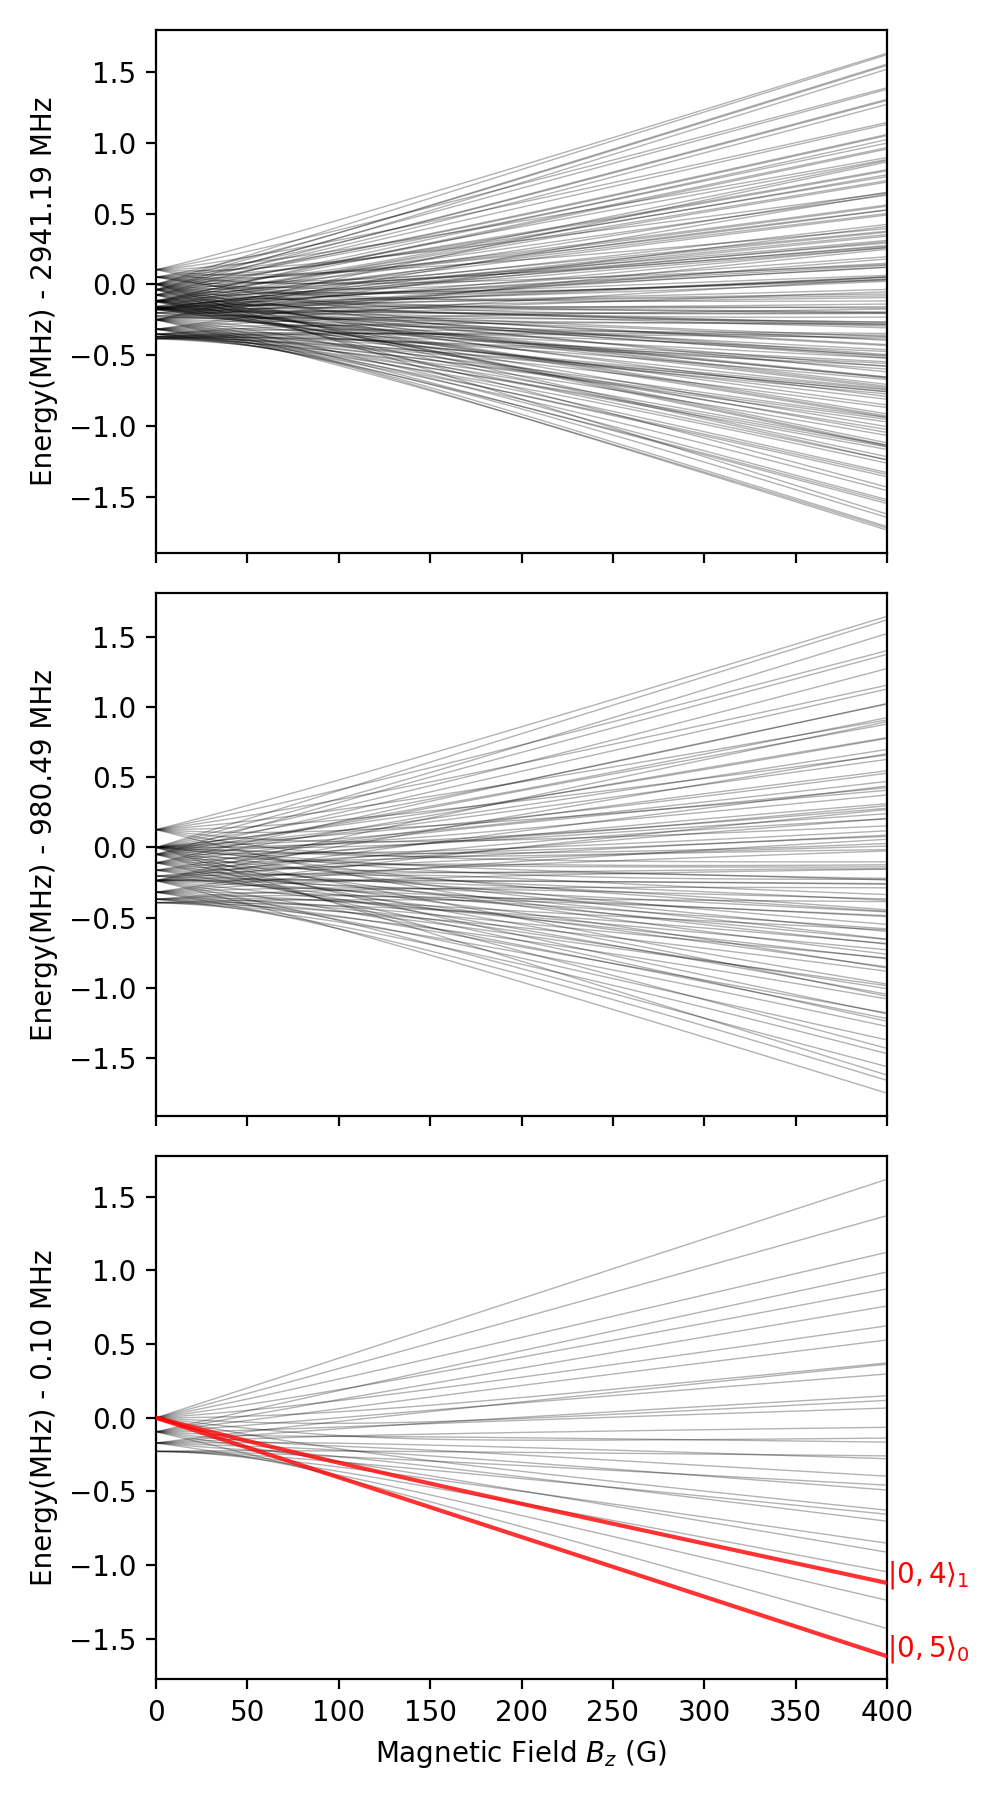

In [10]:
print("plotting zeeman diagram...")
fig, axs = plt.subplots(3,1,figsize=(5,9),sharex = True)

b_max_plot_gauss = 400
b_max_plot_bi = field_to_bi(b_max_plot_gauss)

axs[0].set_xlim(0,b_max_plot_gauss)
axs[-1].set_xlabel('Magnetic Field $B_z$ (G)')

N=N_MAX
for ax in axs:
    base_energy = np.abs(ENERGIES[PER_MN*(N)**2,0]/(scipy.constants.h*1e6))
    ax.set_ylabel(f'Energy(MHz) - {base_energy:.2f} MHz')
    for si in range(PER_MN*(N)**2,PER_MN*(N+1)**2):
        if si in INITIAL_STATE_INDICES:
            ax.plot(B[:b_max_plot_bi]/GAUSS,ENERGIES[si,:b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,c='red',lw=1.5, alpha=0.8,zorder=10)
            ax.text(B[b_max_plot_bi]/GAUSS,ENERGIES[si,b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,f"${label_d_to_latex_string(LABELS_D[si])}$",c='red')
        else:
            ax.plot(B[:b_max_plot_bi]/GAUSS,ENERGIES[si,:b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,c='black',lw=0.5, alpha=0.3,zorder=1)
    N-=1

fig.savefig(f'../images/many-molecules/{MOLECULE_STRING}-zeeman.pdf')

# Magnetic moments plot

plotting magnetic moments...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


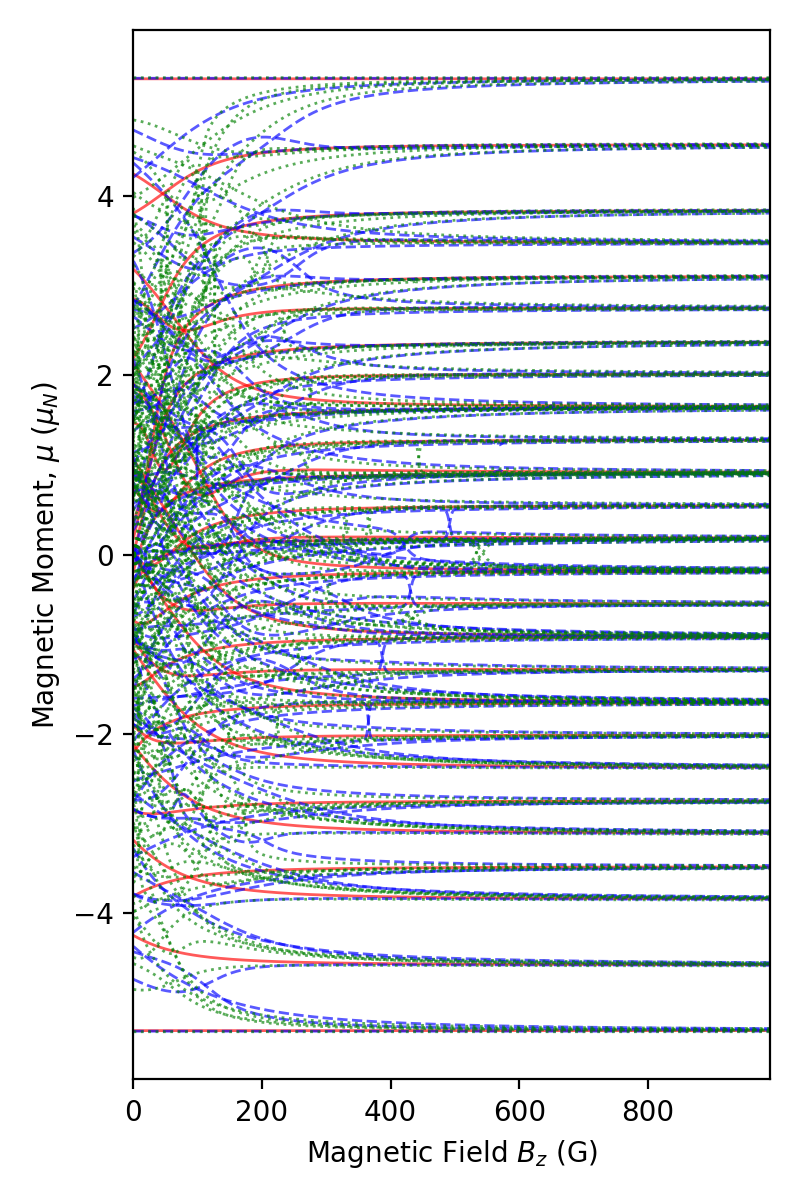

In [11]:
print("plotting magnetic moments...")
fig, ax = plt.subplots(figsize=(4,6))

ax.set_xlim(0,B_MAX/GAUSS)
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Magnetic Moment, $\mu$ $(\mu_N)$')

states_to_plot = []
for N in range(0,3):
    Fd = 2*N + I1_D + I2_D
    for MF_D in range(-Fd,Fd+1,2):
        for di in range(label_degeneracy(N,MF_D)):
            states_to_plot.append((N,MF_D,di))

for state_label in states_to_plot:
    lw=1
    col = 'red'
    ls = 'solid'
    if state_label[0] == 1:
        ls = 'dashed'
        col='blue'
        lw=1
    if state_label[0] == 2:
        ls = 'dotted'
        col='green'
        lw=1
    
    index = label_d_to_node_index(*state_label)
    ax.plot(B/GAUSS, MAGNETIC_MOMENTS[index,:]/muN,linestyle=ls, color=col, alpha=0.65,linewidth=lw);

fig.savefig(f'../images/many-molecules/{MOLECULE_STRING}-magnetic-dipole-moments.pdf')

# Find best state Pi-pulse paths

In [28]:
CUTOFF_TIME = 1e-4
CUTOFF_BI = field_to_bi(181.5)
from pyvis.network import Network
net = Network(height="1000px",width="75%",directed=False,notebook=True,cdn_resources='in_line',neighborhood_highlight=False,layout=None,filter_menu=False)
net.repulsion()

edges = set()

cm = matplotlib.cm.get_cmap('Spectral')
colours = cm(np.linspace(0,1,N_INITIAL_STATES))
colours_hex = [matplotlib.colors.to_hex(c, keep_alpha=False) for c in colours]


for si in range(N_STATES):
    time = CUMULATIVE_TIME_FROM_INITIALS_UNPOL[si,CUTOFF_BI]
    if time < CUTOFF_TIME: # Use me
        # Build tree
        start_label = LABELS_D[si]
        start_si = si
        
        current_back = si
        current_back_label = LABELS_D[si]
        predecessor_list = PREDECESSOR_UNPOL[:,CUTOFF_BI]
        while current_back not in INITIAL_STATE_INDICES:
            next_back = predecessor_list[current_back]
            next_back_label = LABELS_D[next_back]
            edges.add((current_back,next_back))
            current_back = next_back
            current_back_label = next_back_label
        
        this_y=((CUTOFF_TIME-time)/(CUTOFF_TIME))
        this_x=float(
            (
                start_label[1]-current_back_label[1]
                + 2*start_label[2]/label_degeneracy(start_label[0],start_label[1])
            )*0.05)*(1-this_y)**(0.1) + current_back
    
        state_label = LABELS_D[si]
        label_string = label_d_to_string(state_label)
        # net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*2000, value=float(time),color=colours_hex[0],title=f"{label_string}, cumulative time={time}",physics=False)
        net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*4000,color=colours_hex[0],title=f"{label_string}, cumulative time={time}",physics=False)
        
    
pcol = ['blue','red','green']
for s,t in edges:
    fid = 1#float(TRANSITION_GATE_TIMES_UNPOL[t,CUTOFF_BI])
    from_i = int(t)
    to_i = int(s)
    P = round((LABELS_D[from_i][1] - LABELS_D[to_i][1])*(LABELS_D[from_i][0] - LABELS_D[to_i][0])/2)
    ecol = pcol[P]
    net.add_edge(int(t),int(s), value=fidelity(fid,d=5),arrowStrikethrough=False,color=ecol,title=f"{fid}",physics=True)
    

            

# net.prep_notebook()
# net.show_buttons(filter_=['physics'])
net.toggle_physics(False)
net.show('test.html')

# Generic Optimisation Routine

In [13]:
def maximise_fid_dev(possibilities, loop=False, required_crossing=None, max_bi=B_STEPS, allow_travel=True,
                     rate_deviation=True, rate_unpol_distance_time=True, rate_pol_distance_time=False, rate_unpol_time=True, rate_pol_time=False,
                     plot=True, table_len=8, latex_table=False, x_plots=4, y_plots=1, save_name=None):
    n_comb = len(possibilities)
    n_waves = len(possibilities[0]) - 1 # NOTE: assumes paths are the same length
    n_plots = x_plots*y_plots
    consider_top=max(n_plots,table_len)
    print(n_comb, "combinations to consider")
    possibilities_indices = np.array([np.array([label_d_to_node_index(*label) for label in possibility]) for possibility in possibilities])

    # deviation = np.zeros((B_STEPS, consider_top),dtype=np.double)
    unpol_db_req = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_db_req = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    unpol_distance_time = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_distance_time = np.zeros((B_STEPS, consider_top),dtype=np.double)    
    
    unpol_time = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_time = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    rating = 1e20*np.ones((B_STEPS,consider_top),dtype=np.double)
    peak_rating =  1e20*np.ones((consider_top),dtype=np.double)
    peak_rating_index = np.zeros((consider_top),dtype=int)

    worst_rating_time_so_far = 1e20
    for i, desired_indices in tqdm(enumerate(possibilities_indices),total=n_comb):
        this_rating_time = np.zeros((B_STEPS),dtype=np.double)
        
        # Find path to get there from initial state
        if allow_travel:
            this_unpol_distance_time_i = np.argmin(CUMULATIVE_TIME_FROM_INITIALS_UNPOL[desired_indices,:],axis=0)
            this_unpol_distance_time = np.take_along_axis(CUMULATIVE_TIME_FROM_INITIALS_UNPOL[desired_indices,:],np.expand_dims(this_unpol_distance_time_i,axis=0),axis=0)[0]
            this_unpol_distance_pre = np.take_along_axis(PREDECESSOR_UNPOL[desired_indices,:],np.expand_dims(this_unpol_distance_time_i,axis=0),axis=0)[0]
            if rate_unpol_distance_time:
                this_rating_time += this_unpol_distance_time
                if np.min(this_rating_time) > worst_rating_time_so_far:
                    pass
            this_pol_distance_time_i = np.argmin(CUMULATIVE_TIME_FROM_INITIALS_POL[desired_indices,:],axis=0)
            this_pol_distance_time = np.take_along_axis(CUMULATIVE_TIME_FROM_INITIALS_POL[desired_indices,:],np.expand_dims(this_pol_distance_time_i,axis=0),axis=0)[0]
            this_pol_distance_pre = np.take_along_axis(PREDECESSOR_POL[desired_indices,:],np.expand_dims(this_pol_distance_time_i,axis=0),axis=0)[0]
            if rate_pol_distance_time:
                this_rating_time += this_pol_distance_time
                if np.min(this_rating_time) > worst_rating_time_so_far:
                    pass
        else:
            intersection = np.any(np.isin(desired_indices, INITIAL_STATE_INDICES, assume_unique=True))
            if intersection:
                this_unpol_distance_time = np.zeros(B_STEPS)
                this_pol_distance_time = np.zeros(B_STEPS)
            else:
                continue
        
        # Find t_gate to get 9's fidelity
        this_unpol_t_gate = np.zeros(B_STEPS,dtype=np.double)
        this_pol_t_gate = np.zeros(B_STEPS,dtype=np.double)
        for n in range(n_waves):
            this_pol_t_gate = np.maximum(this_pol_t_gate, TRANSITION_GATE_TIMES_POL[label_pair_to_edge_index(LABELS_D[desired_indices[n]],LABELS_D[desired_indices[n+1]]),:])
            this_unpol_t_gate = np.maximum(this_unpol_t_gate, TRANSITION_GATE_TIMES_UNPOL[label_pair_to_edge_index(LABELS_D[desired_indices[n]],LABELS_D[desired_indices[n+1]]),:])
        if loop:
            this_pol_t_gate = np.maximum(this_pol_t_gate, TRANSITION_GATE_TIMES_POL[label_pair_to_edge_index(LABELS_D[desired_indices[0]],LABELS_D[desired_indices[-1]]),:])
            this_unpol_t_gate = np.maximum(this_unpol_t_gate, TRANSITION_GATE_TIMES_UNPOL[label_pair_to_edge_index(LABELS_D[desired_indices[0]],LABELS_D[desired_indices[-1]]),:])
        
        if rate_unpol_time:
            this_rating_time += 10*this_unpol_t_gate # NOTE: THIS 10 is ARBITRARY!!!!!!!!!!!!!!!!!!!!!!!!!!!
            if np.min(this_rating_time) > worst_rating_time_so_far:
                pass
        if rate_pol_time:
            this_rating_time += 10*this_pol_t_gate
            if np.min(this_rating_time) > worst_rating_time_so_far:
                pass
                
        # Find Delta B to get 9's fidelity
        all_moments = MAGNETIC_MOMENTS[desired_indices,:]
        this_deviation = np.abs((np.amax(all_moments,axis=0) - np.amin(all_moments,axis=0)))
        this_delta_b_req_unpol = scipy.constants.h/(this_deviation*this_unpol_t_gate)
        this_delta_b_req_pol = scipy.constants.h/(this_deviation*this_pol_t_gate)
        if rate_deviation:
            this_rating_time *= (1/this_delta_b_req_unpol)
            if required_crossing is not None:
                required_deviation = all_moments[required_crossing[0],:]-all_moments[required_crossing[1],:]
                sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
                mask = np.ones(max_bi, dtype=bool)
                mask[sign_changes] = False
                mask[sign_changes+1] = False
                this_rating_time[mask] += 1e20
            if np.min(this_rating_time) > worst_rating_time_so_far:
                pass
                
        
        this_peak_rating = np.min(this_rating_time)
        better_array = this_peak_rating - peak_rating # want to be negative
        partitioned_array = np.argpartition(better_array, 2)
        the_worst_index = partitioned_array[0]
        the_second_worst_index = partitioned_array[1]
        the_worst_difference = better_array[the_worst_index]
        # print(the_worst_difference)
        if the_worst_difference < 0:
            peak_rating[the_worst_index] = this_peak_rating
            peak_rating_index[the_worst_index] = i

            # deviation[:,the_worst_index] = this_deviation
            unpol_db_req[:,the_worst_index] = this_delta_b_req_unpol
            pol_db_req[:,the_worst_index] = this_delta_b_req_pol
            
            unpol_distance_time[:,the_worst_index] = this_unpol_distance_time
            pol_distance_time[:,the_worst_index] = this_pol_distance_time

            unpol_time[:,the_worst_index] = this_unpol_t_gate
            pol_time[:,the_worst_index] = this_pol_t_gate
        
            rating[:,the_worst_index] = this_rating_time
            worst_rating_time_so_far = max(this_peak_rating,peak_rating[the_second_worst_index])
        else:
            worst_rating_time_so_far = peak_rating[the_worst_index]

    order = (peak_rating).argsort()
    
    # Display Results
    if plot:
        fig, axs = plt.subplots(y_plots,x_plots,figsize=(10,10),dpi=100,sharex=True,sharey=True,constrained_layout=True)
        if n_plots > 1:
            axs = axs.flatten()
        else:
            axs = [axs]
    headers = ['States', 'B(G)', 'UnPolDB', 'PolDB', 'UnPolT(us)', 'PolT(us)', 'UnPolDistT(us)', 'PolDistT(us)', 'Rating', 'Path']
    data = []
    for i in range(table_len):
        besti = order[i]
        combi = peak_rating_index[besti]
        state_labels = possibilities[combi]
        state_numbers = np.array([label_d_to_node_index(*state_label) for state_label in state_labels])
        
        this_rating = rating[:,besti]
        peak_rating_bi = np.argmin(this_rating)
        peak_rating = this_rating[peak_rating_bi]
        peak_magnetic_field = B[peak_rating_bi]

        this_unpol_db_req = unpol_db_req[:,besti]
        this_pol_db_req = pol_db_req[:,besti]
        this_unpol_distance_time = unpol_distance_time[:,besti]
        this_pol_distance_time = pol_distance_time[:,besti]
        this_unpol_time = unpol_time[:,besti]
        this_pol_time = pol_time[:,besti]
        
        peak_unpol_db_req = this_unpol_db_req[peak_rating_bi]
        peak_pol_db_req = this_pol_db_req[peak_rating_bi]
        peak_pol_distance_time = this_pol_distance_time[peak_rating_bi]
        peak_unpol_distance_time = this_unpol_distance_time[peak_rating_bi]
        peak_unpol_time = this_unpol_time[peak_rating_bi]
        peak_pol_time = this_pol_time[peak_rating_bi]
        
        if plot and i<n_plots:
            ax = axs[i]
            ax.set_xlim(0,B_MAX/GAUSS)
            ax.set_ylim(0,6)
            
            ax.plot(B/GAUSS, np.log10(1e-12+this_unpol_distance_time*1e6), linestyle='dashed', c='red', alpha=0.4)
            ax.plot(B/GAUSS, np.log10(1e-12+this_pol_distance_time*1e6), linestyle='dashed', c='green', alpha=0.4)

            ax.plot(B/GAUSS, np.log10(1e-12+this_unpol_time*1e6), linestyle='solid', c='red', alpha=0.6)
            ax.plot(B/GAUSS, np.log10(1e-12+this_pol_time*1e6), linestyle='solid', c='green', alpha=0.6)
            
            at_field = B[peak_rating_bi]/GAUSS
            lower_inset_bi = field_to_bi(at_field-20)
            upper_inset_bi = field_to_bi(at_field+20)
            
            axinset = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
            axinset.plot(B[lower_inset_bi:upper_inset_bi]/GAUSS,MAGNETIC_MOMENTS[state_numbers,lower_inset_bi:upper_inset_bi].T/muN)
            axinset.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
            
            ax.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
        
        peak_unpol_distance_pre = PREDECESSOR_UNPOL[:,peak_rating_bi]
        current_state = state_numbers[this_pol_distance_time_i[peak_rating_bi]]
        path = []
        while current_state >= 0:
            path.append(LABELS_D[current_state])
            current_state = peak_unpol_distance_pre[current_state]
            
        if len(path) <= 3:
            path_string = "<".join([label_d_to_string(label) for label in path])
        else:
            path_string = "<".join([label_d_to_string(label) for label in path[:1]])
            path_string += f"<(+{len(path)-2})<"
            path_string += "<".join([label_d_to_string(label) for label in path[len(path)-1:]])
        
        states_string = ",".join([label_d_to_string(label) for label in state_labels])
        string_list = [states_string,
                       f"{peak_magnetic_field/GAUSS:6.1f}",
                       peak_unpol_db_req,
                       peak_pol_db_req,
                       f"{peak_unpol_time*1e6:.3f}",
                       f"{peak_pol_time*1e6:.3f}",
                       f"{peak_unpol_distance_time*1e6:.3f}",
                       f"{peak_pol_distance_time*1e6:.3f}",
                       f"{peak_rating:.2f}",
                       path_string]
        data.append(string_list)
    
    html_table = tabulate(data, headers=headers,tablefmt="html")
    if latex_table:
        with open(f"../tables/{save_name}.tex", "w") as text_file:
            text_file.write(tabulate(data, headers=headers, tablefmt="latex_raw"))
    if plot:
        fig.supxlabel('Magnetic Field $B_z$ (G)')
        fig.supylabel('$log_{10} (t)$')
        if save_name is not None:
            fig.savefig(f'../images/many-molecules/{save_name}.pdf')

    return html_table

# Robust Storage Bit Optimisation

In [14]:
print("General Robust Storage Qubit Optimisation")

possibilities = []
for N1 in range(0,N_MAX+1): #[1]:#
    for N2 in [N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

General Robust Storage Qubit Optimisation


187984 combinations to consider


100%|███████████████████████████████████| 187984/187984 [00:39<00:00, 4756.78it/s]
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


'<table>\n<thead>\n<tr><th>States                     </th><th style="text-align: right;">  B(G)</th><th style="text-align: right;">  UnPolDB</th><th style="text-align: right;">      PolDB</th><th style="text-align: right;">  UnPolT(us)</th><th style="text-align: right;">  PolT(us)</th><th style="text-align: right;">  UnPolDistT(us)</th><th style="text-align: right;">  PolDistT(us)</th><th style="text-align: right;">  Rating</th><th>Path                   </th></tr>\n</thead>\n<tbody>\n<tr><td>(1,5,1),(0,4,0),(1,4,1)    </td><td style="text-align: right;"> 323  </td><td style="text-align: right;"> 6.2668  </td><td style="text-align: right;">  35.6007  </td><td style="text-align: right;">      26.548</td><td style="text-align: right;">     4.673</td><td style="text-align: right;">          55.499</td><td style="text-align: right;">        16.801</td><td style="text-align: right;">       0</td><td>(1,5,1)&lt;(+2)&lt;(0,4,1)   </td></tr>\n<tr><td>(1,4,2),(0,3,0),(1,3,1)    </td><td style="text-align: right;"> 381  </td><td style="text-align: right;"> 2.96736 </td><td style="text-align: right;">  32.1937  </td><td style="text-align: right;">      26.277</td><td style="text-align: right;">     2.422</td><td style="text-align: right;">         141.175</td><td style="text-align: right;">        50.626</td><td style="text-align: right;">       0</td><td>(1,4,2)&lt;(+4)&lt;(0,4,1)   </td></tr>\n<tr><td>(1,4,2),(0,3,0),(1,3,0)    </td><td style="text-align: right;"> 166  </td><td style="text-align: right;"> 1.83621 </td><td style="text-align: right;">   3.85071 </td><td style="text-align: right;">      41.138</td><td style="text-align: right;">    19.617</td><td style="text-align: right;">         162.205</td><td style="text-align: right;">        41.557</td><td style="text-align: right;">       0</td><td>(1,4,2)&lt;(+4)&lt;(0,4,1)   </td></tr>\n<tr><td>(1,3,3),(0,2,0),(1,2,1)    </td><td style="text-align: right;"> 406  </td><td style="text-align: right;"> 1.62117 </td><td style="text-align: right;">  27.2145  </td><td style="text-align: right;">      30.294</td><td style="text-align: right;">     1.805</td><td style="text-align: right;">         226.223</td><td style="text-align: right;">        72.968</td><td style="text-align: right;">       0</td><td>(1,3,3)&lt;(+6)&lt;(0,4,1)   </td></tr>\n<tr><td>(1,2,4),(0,1,0),(1,1,1)    </td><td style="text-align: right;"> 395  </td><td style="text-align: right;"> 1.03428 </td><td style="text-align: right;">  18.356   </td><td style="text-align: right;">      31.688</td><td style="text-align: right;">     1.785</td><td style="text-align: right;">         294.048</td><td style="text-align: right;">        93.368</td><td style="text-align: right;">       0</td><td>(1,2,4)&lt;(+8)&lt;(0,4,1)   </td></tr>\n<tr><td>(1,-1,4),(0,-2,0),(1,-2,1) </td><td style="text-align: right;"> 225  </td><td style="text-align: right;"> 1.04014 </td><td style="text-align: right;">   1.67707 </td><td style="text-align: right;">      23.24 </td><td style="text-align: right;">    14.414</td><td style="text-align: right;">         422.172</td><td style="text-align: right;">       147.093</td><td style="text-align: right;">       0</td><td>(1,-1,4)&lt;(+10)&lt;(0,5,0) </td></tr>\n<tr><td>(2,-1,3),(1,-2,1),(2,-3,1) </td><td style="text-align: right;"> 530  </td><td style="text-align: right;"> 2.0525  </td><td style="text-align: right;">1551.42    </td><td style="text-align: right;">     110.857</td><td style="text-align: right;">     0.147</td><td style="text-align: right;">         720.28 </td><td style="text-align: right;">       188.617</td><td style="text-align: right;">       0</td><td>(2,-1,3)&lt;(+11)&lt;(0,4,1) </td></tr>\n<tr><td>(1,1,3),(0,0,0),(1,0,1)    </td><td style="text-align: right;"> 352  </td><td style="text-align: right;"> 0.729536</td><td style="text-align: right;">   9.17481 </td><td style="text-align: right;">      30.178</td><td style="text-align: right;">     2.4  </td><td style="text-align: right

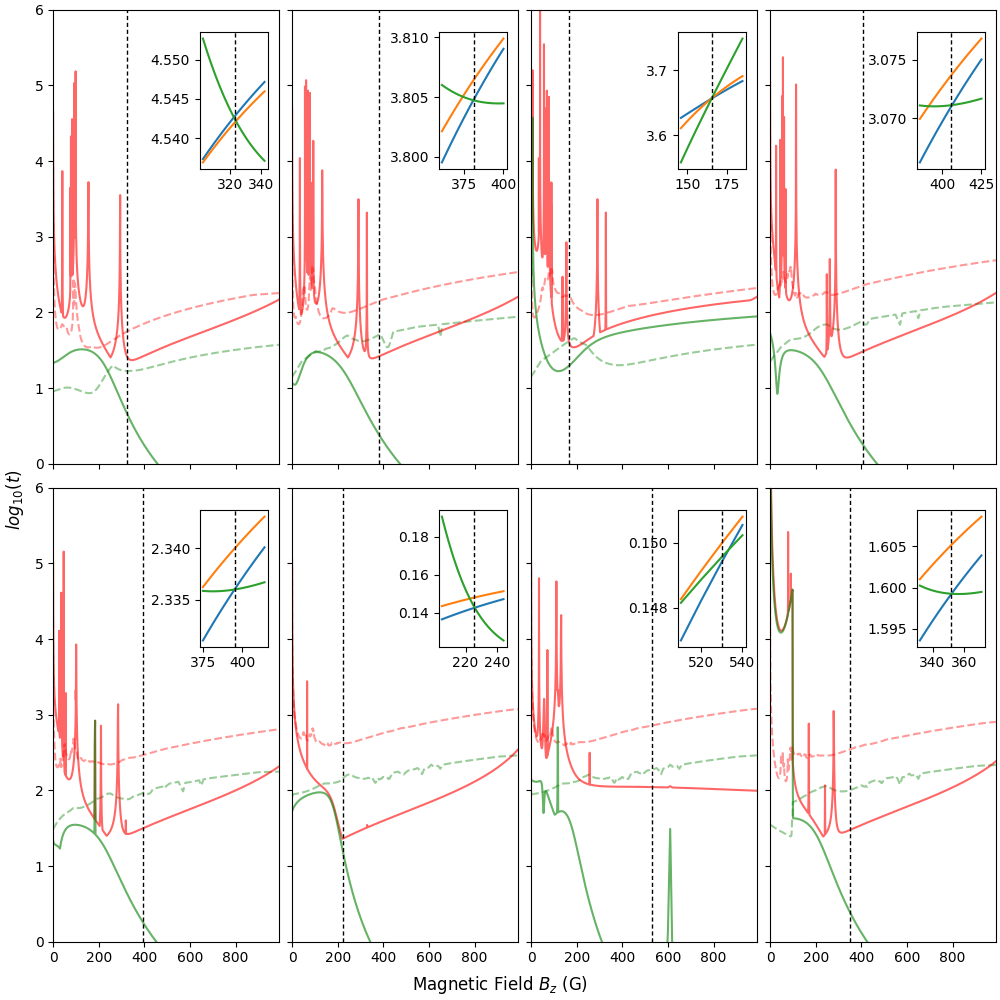

In [15]:
maximise_fid_dev(possibilities_d[:,:],latex_table=True,required_crossing=[0,2],save_name=f"{MOLECULE_STRING}-qubit",rate_deviation=True,table_len=20,rate_pol_distance_time=False,rate_pol_time=False,x_plots=4,y_plots=2)

# Robust Storage Bit in N=0 Optimisation

In [16]:
print("Robust Storage Qubit N=0 Op}timisation")

possibilities = []
for N1 in [1]: #range(0,N_MAX+1): #[1]:#
    for N2 in [0]: #[N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

Robust Storage Qubit N=0 Op}timisation


4432 combinations to consider


100%|███████████████████████████████████████| 4432/4432 [00:01<00:00, 3718.56it/s]
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


'<table>\n<thead>\n<tr><th>States                    </th><th style="text-align: right;">  B(G)</th><th style="text-align: right;">  UnPolDB</th><th style="text-align: right;">    PolDB</th><th style="text-align: right;">  UnPolT(us)</th><th style="text-align: right;">  PolT(us)</th><th style="text-align: right;">  UnPolDistT(us)</th><th style="text-align: right;">  PolDistT(us)</th><th style="text-align: right;">  Rating</th><th>Path                   </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,1,3),(1,0,8),(0,0,2)   </td><td style="text-align: right;"> 171  </td><td style="text-align: right;">0.295299 </td><td style="text-align: right;">1.57531  </td><td style="text-align: right;">     116.501</td><td style="text-align: right;">    21.839</td><td style="text-align: right;">         116.877</td><td style="text-align: right;">        27.12 </td><td style="text-align: right;">    0   </td><td>(0,1,3)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,4,1),(1,4,5),(0,4,0)   </td><td style="text-align: right;">  45.6</td><td style="text-align: right;">0.0917425</td><td style="text-align: right;">0.407712 </td><td style="text-align: right;">      61.581</td><td style="text-align: right;">    13.857</td><td style="text-align: right;">           0    </td><td style="text-align: right;">         0    </td><td style="text-align: right;">    0.01</td><td>(0,4,1)                </td></tr>\n<tr><td>(0,4,1),(1,3,1),(0,3,0)   </td><td style="text-align: right;"> 154  </td><td style="text-align: right;">0.0601174</td><td style="text-align: right;">0.12325  </td><td style="text-align: right;">     102.807</td><td style="text-align: right;">    50.146</td><td style="text-align: right;">           0    </td><td style="text-align: right;">         0    </td><td style="text-align: right;">    0.02</td><td>(0,4,1)                </td></tr>\n<tr><td>(0,1,1),(1,1,5),(0,0,0)   </td><td style="text-align: right;">  19.6</td><td style="text-align: right;">0.144681 </td><td style="text-align: right;">0.795632 </td><td style="text-align: right;">     248.085</td><td style="text-align: right;">    45.113</td><td style="text-align: right;">         285.102</td><td style="text-align: right;">        39.588</td><td style="text-align: right;">    0.02</td><td>(0,1,1)&lt;(+3)&lt;(0,5,0)   </td></tr>\n<tr><td>(0,1,3),(1,0,3),(0,1,2)   </td><td style="text-align: right;">  84.6</td><td style="text-align: right;">0.0355091</td><td style="text-align: right;">0.168764 </td><td style="text-align: right;">      47.967</td><td style="text-align: right;">    10.093</td><td style="text-align: right;">         269.435</td><td style="text-align: right;">        34.749</td><td style="text-align: right;">    0.02</td><td>(0,1,3)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,2,3),(1,1,8),(0,1,2)   </td><td style="text-align: right;"> 177  </td><td style="text-align: right;">0.0269135</td><td style="text-align: right;">0.0865622</td><td style="text-align: right;">      95.348</td><td style="text-align: right;">    29.645</td><td style="text-align: right;">          33.515</td><td style="text-align: right;">         9.621</td><td style="text-align: right;">    0.04</td><td>(0,2,3)&lt;(1,3,2)&lt;(0,4,1)</td></tr>\n<tr><td>(0,0,3),(1,-1,8),(0,-1,2) </td><td style="text-align: right;"> 157  </td><td style="text-align: right;">0.0254003</td><td style="text-align: right;">0.0624503</td><td style="text-align: right;">      74.812</td><td style="text-align: right;">    30.428</td><td style="text-align: right;">         191.293</td><td style="text-align: right;">        44.049</td><td style="text-align: right;">    0.04</td><td>(0,0,3)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,2,0),(1,1,0),(0,1,1)   </td><td style="text-align: right;">  11.8</td><td style="text-align: right;">0.154322 </td><td style="text-align: right;">3.04014  </td><td style="text-align: right;">     568.018</td><td style="text-align: right;">    28.834</td><td style="text-align: right;">         318.194</td><td style="text

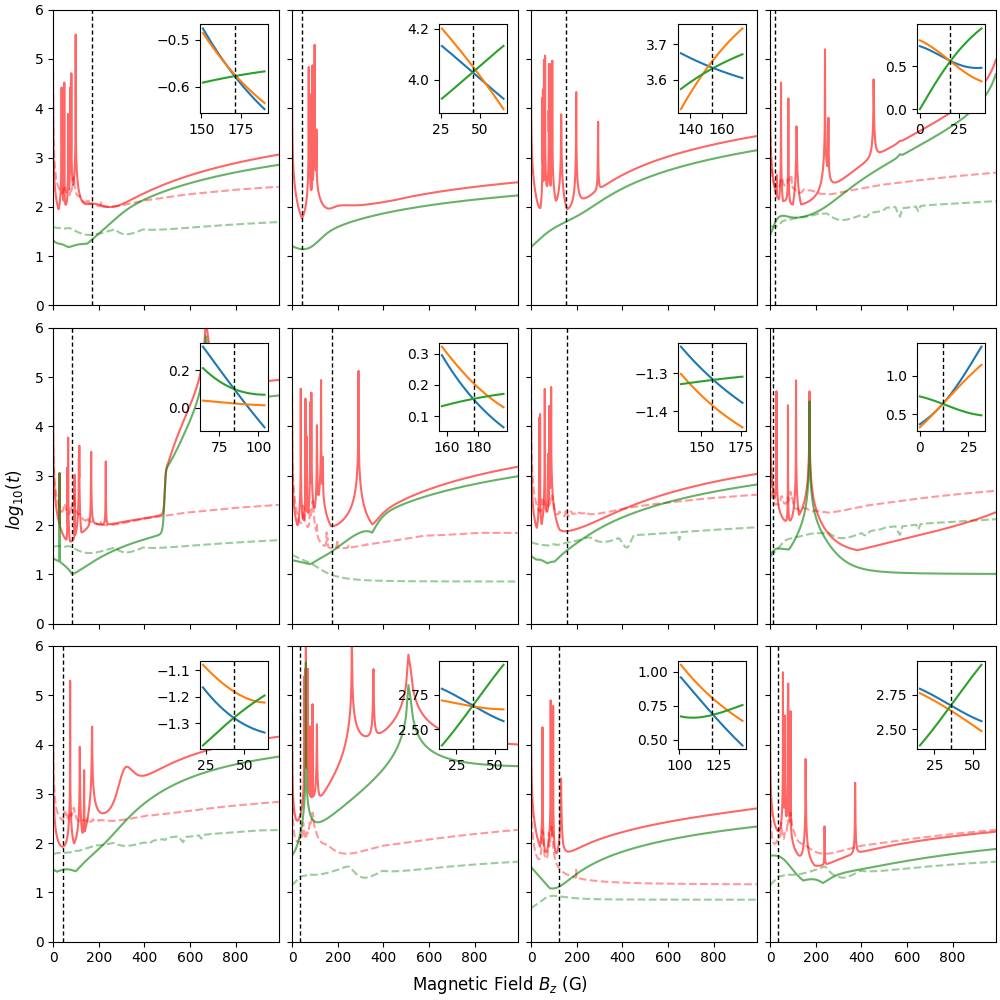

In [29]:
maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],table_len=12,x_plots=4,y_plots=3,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)

# Varying time for a set of states

# 2-state

In [25]:
print("2-state optimisation")

states=[]
for N1 in range(0,N_MAX): #[1]:#
    N2=N1+1
    F1_D = 2*N1+I1_D+I2_D
    for MF1_D in range(-F1_D,F1_D+1,2):
        for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    states.append([(N1,MF1_D,i),(N2,MF2_D,j)])           
states=np.array(states)

2-state optimisation


5300 combinations to consider


100%|███████████████████████████████████████| 5300/5300 [00:00<00:00, 6349.82it/s]
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


'<table>\n<thead>\n<tr><th>States            </th><th style="text-align: right;">  B(G)</th><th style="text-align: right;">  UnPolDB</th><th style="text-align: right;">       PolDB</th><th style="text-align: right;">  UnPolT(us)</th><th style="text-align: right;">  PolT(us)</th><th style="text-align: right;">  UnPolDistT(us)</th><th style="text-align: right;">  PolDistT(us)</th><th style="text-align: right;">  Rating</th><th>Path                  </th></tr>\n</thead>\n<tbody>\n<tr><td>(1,6,0),(2,7,0)   </td><td style="text-align: right;">   216</td><td style="text-align: right;"> 3.15632 </td><td style="text-align: right;">    4.0158  </td><td style="text-align: right;">       6.704</td><td style="text-align: right;">     5.269</td><td style="text-align: right;">          17.193</td><td style="text-align: right;">         0.006</td><td style="text-align: right;">       0</td><td>(1,6,0)&lt;(0,5,0)       </td></tr>\n<tr><td>(1,-4,0),(2,-5,0) </td><td style="text-align: right;">   155</td><td style="text-align: right;"> 0.246716</td><td style="text-align: right;">    0.302302</td><td style="text-align: right;">       6.886</td><td style="text-align: right;">     5.62 </td><td style="text-align: right;">         524.284</td><td style="text-align: right;">       127.182</td><td style="text-align: right;">       0</td><td>(1,-4,0)&lt;(+10)&lt;(0,4,1)</td></tr>\n<tr><td>(1,2,3),(2,1,5)   </td><td style="text-align: right;">   272</td><td style="text-align: right;"> 0.284284</td><td style="text-align: right;">    2.6706  </td><td style="text-align: right;">       7.064</td><td style="text-align: right;">     0.752</td><td style="text-align: right;">          52.042</td><td style="text-align: right;">         9.459</td><td style="text-align: right;">       0</td><td>(1,2,3)&lt;(+2)&lt;(0,5,0)  </td></tr>\n<tr><td>(1,5,1),(2,6,1)   </td><td style="text-align: right;">   289</td><td style="text-align: right;"> 2.68357 </td><td style="text-align: right;">    3.09364 </td><td style="text-align: right;">       7.289</td><td style="text-align: right;">     6.323</td><td style="text-align: right;">          99.787</td><td style="text-align: right;">        17.625</td><td style="text-align: right;">       0</td><td>(1,5,1)&lt;(+2)&lt;(0,5,0)  </td></tr>\n<tr><td>(1,-5,0),(2,-6,0) </td><td style="text-align: right;">   234</td><td style="text-align: right;"> 0.841245</td><td style="text-align: right;">    0.91691 </td><td style="text-align: right;">       7.294</td><td style="text-align: right;">     6.692</td><td style="text-align: right;">         477.853</td><td style="text-align: right;">       151.472</td><td style="text-align: right;">       0</td><td>(1,-5,0)&lt;(+12)&lt;(0,5,0)</td></tr>\n<tr><td>(1,4,2),(2,5,2)   </td><td style="text-align: right;">   304</td><td style="text-align: right;"> 1.37037 </td><td style="text-align: right;">    8.23752 </td><td style="text-align: right;">       7.423</td><td style="text-align: right;">     1.235</td><td style="text-align: right;">         169.53 </td><td style="text-align: right;">        44.537</td><td style="text-align: right;">       0</td><td>(1,4,2)&lt;(+4)&lt;(0,4,1)  </td></tr>\n<tr><td>(1,3,3),(2,4,4)   </td><td style="text-align: right;">   308</td><td style="text-align: right;"> 1.24008 </td><td style="text-align: right;">    2.68779 </td><td style="text-align: right;">       7.493</td><td style="text-align: right;">     3.457</td><td style="text-align: right;">         225.138</td><td style="text-align: right;">        62.53 </td><td style="text-align: right;">       0</td><td>(1,3,3)&lt;(+6)&lt;(0,5,0)  </td></tr>\n<tr><td>(1,-3,1),(2,-4,1) </td><td style="text-align: right;">   189</td><td style="text-align: right;"> 0.250741</td><td style="text-align: right;">    3.41717 </td><td style="text-align: right;">       7.506</td><td style="text-align: right;">     0.551</td><td style="text-align: right;">         386.062</td><td style="text-align: right;">       115.697</td><td style

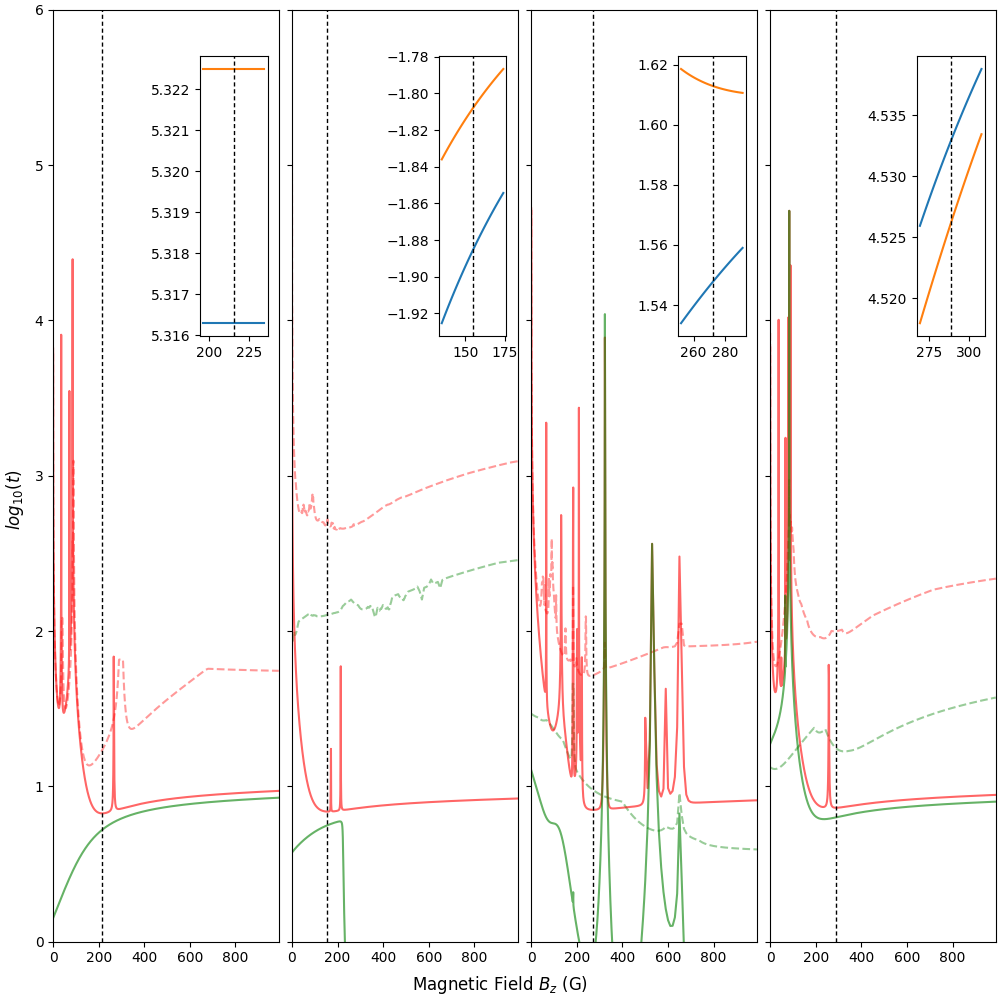

In [27]:
maximise_fid_dev(states,latex_table=True,save_name=f"{MOLECULE_STRING}-2-state", table_len=20,
                rate_deviation=False, rate_unpol_distance_time=False, rate_pol_distance_time=False, rate_unpol_time=True, rate_pol_time=False,)


# 3-state

In [20]:
print("3-state optimisation")

states=[]
N1=0
N2=1
N3=2
F1_D = 2*N1+I1_D+I2_D
for MF1_D in range(-F1_D,F1_D+1,2):
    for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
        for MF3_D in [MF2_D-2,MF2_D,MF2_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    for k in range(label_degeneracy(N3,MF3_D)):
                        states.append([(N1,MF1_D,i),(N2,MF2_D,j),(N3,MF3_D,k)])           
states=np.array(states)

3-state optimisation


45744 combinations to consider


100%|█████████████████████████████████████| 45744/45744 [00:08<00:00, 5213.71it/s]
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


'<table>\n<thead>\n<tr><th>States                   </th><th style="text-align: right;">  B(G)</th><th style="text-align: right;">  UnPolDB</th><th style="text-align: right;">    PolDB</th><th style="text-align: right;">  UnPolT(us)</th><th style="text-align: right;">  PolT(us)</th><th style="text-align: right;">  UnPolDistT(us)</th><th style="text-align: right;">  PolDistT(us)</th><th style="text-align: right;">  Rating</th><th>Path                   </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,3,0),(1,4,2),(2,5,2)  </td><td style="text-align: right;">   165</td><td style="text-align: right;"> 11.0018 </td><td style="text-align: right;"> 54.7254 </td><td style="text-align: right;">      17.033</td><td style="text-align: right;">     3.424</td><td style="text-align: right;">         162.96 </td><td style="text-align: right;">        41.207</td><td style="text-align: right;">       0</td><td>(0,3,0)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,2,0),(1,3,3),(2,4,4)  </td><td style="text-align: right;">   479</td><td style="text-align: right;"> 20.0038 </td><td style="text-align: right;">221.979  </td><td style="text-align: right;">      37.663</td><td style="text-align: right;">     3.394</td><td style="text-align: right;">         269.596</td><td style="text-align: right;">        86.901</td><td style="text-align: right;">       0</td><td>(0,2,0)&lt;(+5)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,1,0),(1,2,4),(2,3,6)  </td><td style="text-align: right;">   484</td><td style="text-align: right;"> 13.0838 </td><td style="text-align: right;">157.99   </td><td style="text-align: right;">      41.114</td><td style="text-align: right;">     3.405</td><td style="text-align: right;">         362.209</td><td style="text-align: right;">       113.578</td><td style="text-align: right;">       0</td><td>(0,1,0)&lt;(+7)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,4,0),(1,5,1),(2,6,1)  </td><td style="text-align: right;">   364</td><td style="text-align: right;">  3.21218</td><td style="text-align: right;"> 11.5791 </td><td style="text-align: right;">      24.045</td><td style="text-align: right;">     6.671</td><td style="text-align: right;">          78.055</td><td style="text-align: right;">        17.14 </td><td style="text-align: right;">       0</td><td>(0,4,0)&lt;(1,4,1)&lt;(0,4,1)</td></tr>\n<tr><td>(0,0,0),(1,1,3),(2,2,7)  </td><td style="text-align: right;">   464</td><td style="text-align: right;">  5.87874</td><td style="text-align: right;"> 68.8489 </td><td style="text-align: right;">      41.885</td><td style="text-align: right;">     3.576</td><td style="text-align: right;">         435.526</td><td style="text-align: right;">       136.592</td><td style="text-align: right;">       0</td><td>(0,0,0)&lt;(+7)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,5,0),(1,6,0),(2,7,0)  </td><td style="text-align: right;">   158</td><td style="text-align: right;">  0.77525</td><td style="text-align: right;">  2.45311</td><td style="text-align: right;">      13.647</td><td style="text-align: right;">     4.313</td><td style="text-align: right;">           0    </td><td style="text-align: right;">         0    </td><td style="text-align: right;">       0</td><td>(0,5,0)                </td></tr>\n<tr><td>(0,-1,0),(1,0,4),(2,1,8) </td><td style="text-align: right;">   414</td><td style="text-align: right;">  4.64519</td><td style="text-align: right;">548.728  </td><td style="text-align: right;">      38.994</td><td style="text-align: right;">     0.33 </td><td style="text-align: right;">         489.169</td><td style="text-align: right;">       128.03 </td><td style="text-align: right;">       0</td><td>(0,-1,0)&lt;(+9)&lt;(0,4,1)  </td></tr>\n<tr><td>(0,-2,0),(1,-1,4),(2,0,7)</td><td style="text-align: right;">   300</td><td style="text-align: right;">  3.62728</td><td style="text-align: right;">  9.68825</td><td style="text-align: right;">      29.623</td><td style="text-align: right;">    11.091</td><td style="text-align: right;">         466.047</td><td style="text-al

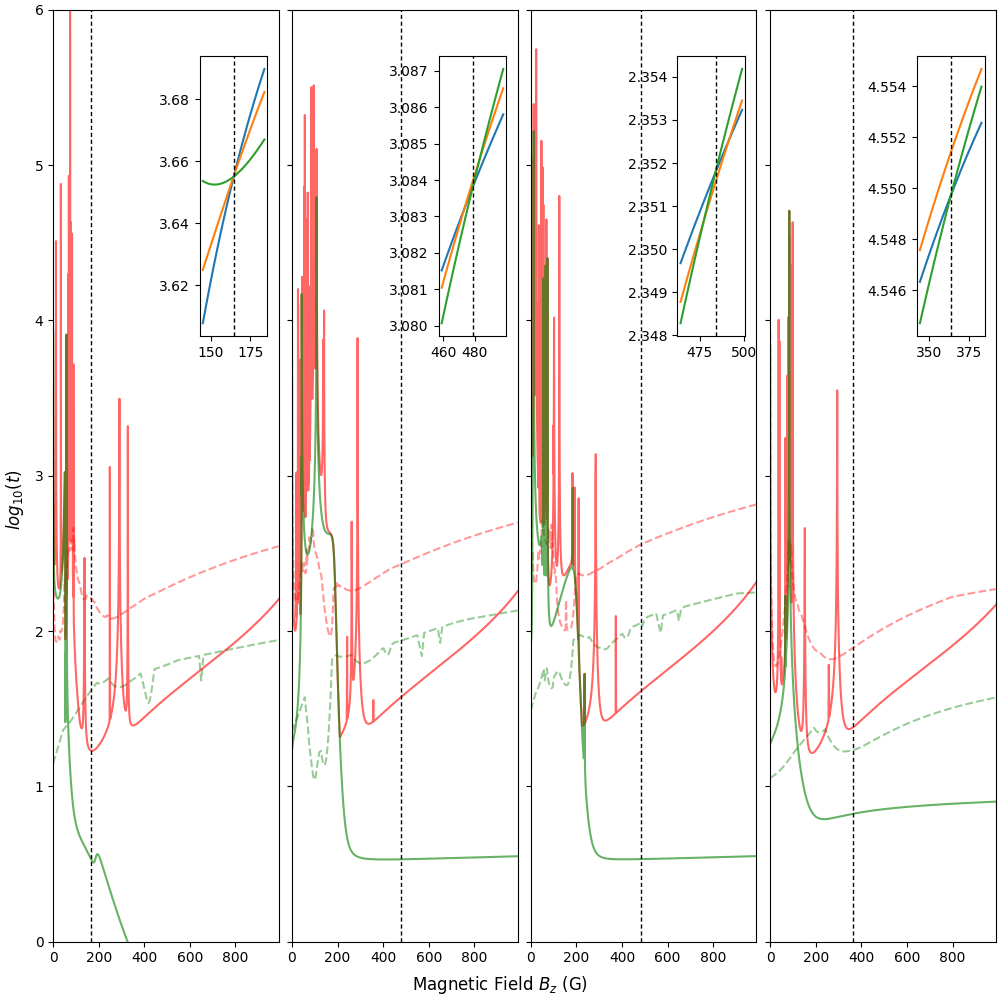

In [21]:
maximise_fid_dev(states,latex_table=True, save_name=f"{MOLECULE_STRING}-3-state")

# 4-state loop Optimisation

In [22]:
print("4-state loop optimisation")

# Find all possible combinations
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = []            
F1_D = I1_D+I2_D
for base_mf_d in range(-F1_D,F1_D+1,2):
    for p1,p2,p3,_ in polarisations:
        state_mfs.append((base_mf_d,base_mf_d+2*p1,base_mf_d+2*p1+2*p2,base_mf_d+2*p1+2*p2+2*p3))

states = []
for state_mf in state_mfs:
    for i in range(label_degeneracy(0,state_mf[0])):
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)

4-state loop optimisation


504014 combinations to consider


100%|███████████████████████████████████| 504014/504014 [01:58<00:00, 4239.78it/s]
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


'<table>\n<thead>\n<tr><th>States                         </th><th style="text-align: right;">  B(G)</th><th style="text-align: right;">  UnPolDB</th><th style="text-align: right;">    PolDB</th><th style="text-align: right;">  UnPolT(us)</th><th style="text-align: right;">  PolT(us)</th><th style="text-align: right;">  UnPolDistT(us)</th><th style="text-align: right;">  PolDistT(us)</th><th style="text-align: right;">  Rating</th><th>Path                   </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,2,0),(1,3,3),(2,2,3),(1,2,1)</td><td style="text-align: right;"> 448  </td><td style="text-align: right;">0.172726 </td><td style="text-align: right;">14.824   </td><td style="text-align: right;">     103.065</td><td style="text-align: right;">     1.201</td><td style="text-align: right;">         245.274</td><td style="text-align: right;">        82.978</td><td style="text-align: right;">    0.01</td><td>(0,2,0)&lt;(+5)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,1,0),(1,2,4),(2,1,3),(1,1,1)</td><td style="text-align: right;"> 423  </td><td style="text-align: right;">0.172582 </td><td style="text-align: right;">13.4542  </td><td style="text-align: right;">     103.533</td><td style="text-align: right;">     1.328</td><td style="text-align: right;">         311    </td><td style="text-align: right;">        91.12 </td><td style="text-align: right;">    0.01</td><td>(0,1,0)&lt;(+5)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,3,0),(1,4,2),(2,3,2),(1,3,1)</td><td style="text-align: right;"> 439  </td><td style="text-align: right;">0.115377 </td><td style="text-align: right;"> 9.24318 </td><td style="text-align: right;">     107.683</td><td style="text-align: right;">     1.344</td><td style="text-align: right;">         159.403</td><td style="text-align: right;">        49.79 </td><td style="text-align: right;">    0.01</td><td>(0,3,0)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,0,0),(1,1,3),(2,0,3),(1,0,1)</td><td style="text-align: right;"> 375  </td><td style="text-align: right;">0.123734 </td><td style="text-align: right;"> 7.5667  </td><td style="text-align: right;">     108.844</td><td style="text-align: right;">     1.78 </td><td style="text-align: right;">         372.916</td><td style="text-align: right;">       107.602</td><td style="text-align: right;">    0.01</td><td>(0,0,0)&lt;(+9)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,3,0),(1,3,8),(2,4,1),(1,3,4)</td><td style="text-align: right;">  34.1</td><td style="text-align: right;">0.167584 </td><td style="text-align: right;"> 0.205633</td><td style="text-align: right;">     214.455</td><td style="text-align: right;">   174.774</td><td style="text-align: right;">          47.328</td><td style="text-align: right;">         6.182</td><td style="text-align: right;">    0.01</td><td>(0,3,0)&lt;(1,4,5)&lt;(0,5,0)</td></tr>\n<tr><td>(0,2,0),(1,3,3),(2,3,3),(1,2,1)</td><td style="text-align: right;"> 840  </td><td style="text-align: right;">0.10145  </td><td style="text-align: right;"> 0.118584</td><td style="text-align: right;">     103.894</td><td style="text-align: right;">    88.882</td><td style="text-align: right;">         418.776</td><td style="text-align: right;">       124.03 </td><td style="text-align: right;">    0.01</td><td>(0,2,0)&lt;(+5)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,3,0),(1,4,2),(2,4,2),(1,3,1)</td><td style="text-align: right;"> 870  </td><td style="text-align: right;">0.0934268</td><td style="text-align: right;"> 0.109739</td><td style="text-align: right;">     105.146</td><td style="text-align: right;">    89.517</td><td style="text-align: right;">         300.343</td><td style="text-align: right;">        81.071</td><td style="text-align: right;">    0.01</td><td>(0,3,0)&lt;(+3)&lt;(0,4,1)   </td></tr>\n<tr><td>(0,1,0),(1,2,4),(2,2,4),(1,1,1)</td><td style="text-align: right;"> 810  </td><td style="text-align: right;">0.10229  </td><td style="text-align: right;"> 0.119761</td><td style="text-align: right;">     103.604</td><td style="text-align: right;">    88.491</td><td style=

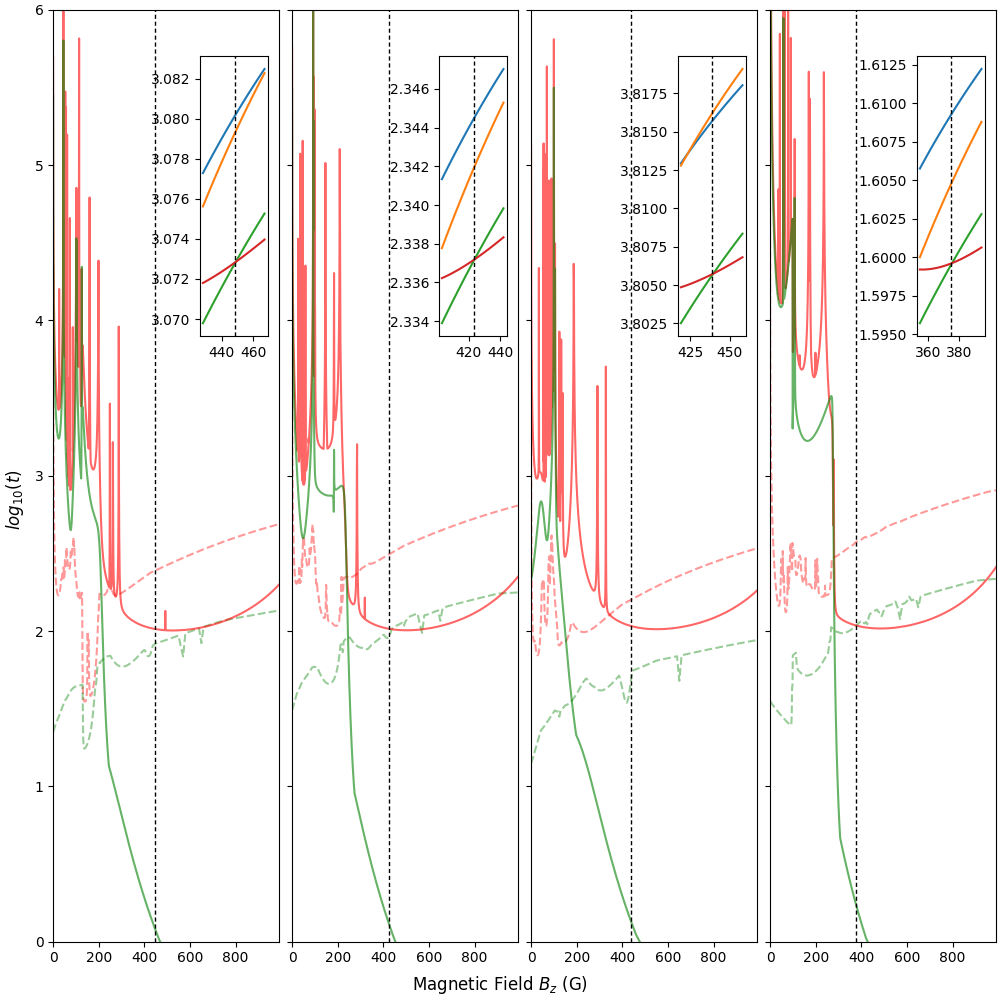

In [23]:
maximise_fid_dev(states,loop=True,latex_table=True,save_name=f"{MOLECULE_STRING}-4-state")

# Optimise in terms of t_g

In [24]:
states = [(0,8,1),(1,8,0),(0,8,0)]
desired_indices = [label_d_to_node_index(*label) for label in states]


# Find best B for minimum dipole deviation
all_moments = MAGNETIC_MOMENTS[:,desired_indices]
this_deviation = np.abs((np.amax(all_moments,axis=1) - np.amin(all_moments,axis=1)))

DESIRED_FIDELITY = 0.999

# required_deviation = all_moments[:,0]-all_moments[:,2]
# sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
# mask = np.ones(max_bi, dtype=bool)
# mask[sign_changes] = False
# mask[sign_changes+1] = False
# this_rating[mask] = 0

# Find best times
t_required_global_max_unpol = np.zeros(B_STEPS, dtype=np.double)
t_required_global_max_pol = np.zeros(B_STEPS, dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label

    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]
    
    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    deltas_up   = np.abs(ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])/H_BAR
    deltas_down = np.abs(ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])/H_BAR
    
    mask_up = up_node_indices == to_node_index
    mask_down = down_node_indices == from_node_index
    
    deltas_up[mask_up,:] = 1e9*np.ones(B_STEPS)
    deltas_down[mask_down,:] = 1e9*np.ones(B_STEPS)

    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)
    
    ###
    t_required_up_unpol = (2*gs_up*np.pi)/(deltas_up)    
    t_required_down_unpol = (2*gs_down*np.pi)/(deltas_down)
    t_required_max_up_unpol = np.max(t_required_up_unpol, axis=0, initial=0)
    t_required_max_down_unpol = np.max(t_required_down_unpol, axis=0, initial=0)
    t_required_max_unpol = np.maximum(t_required_max_up_unpol,t_required_max_down_unpol)
    t_required_global_max_unpol = np.maximum(t_required_max_unpol,t_required_global_max_unpol)
    
    start_index_from = from_neighbours[0]
    start_index_to = to_neighbours[0]
    t_required_up_pol = t_required_up_unpol[from_neighbours[section_index]-start_index_from:from_neighbours[section_index+1]-start_index_from,:]
    t_required_down_pol = t_required_down_unpol[to_neighbours[section_index+3]-start_index_to:to_neighbours[section_index+4]-start_index_to,:]
    t_required_max_up_pol = np.max(t_required_up_pol, axis=0, initial=0)    
    t_required_max_down_pol = np.max(t_required_down_pol, axis=0, initial=0)
    t_required_max_pol = np.maximum(t_required_max_up_pol,t_required_max_down_pol)
    t_required_global_max_pol = np.maximum(t_required_max_pol,t_required_global_max_pol)
    
delta_b_required_unpol = (scipy.constants.h) / (this_deviation * t_required_global_max_unpol)
delta_b_required_pol = (scipy.constants.h) / (this_deviation * t_required_global_max_pol)

NameError: name 'generated_edge_indices' is not defined

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,constrained_layout=True)
ax1.set_xlim(0,B_MAX/GAUSS)

# Simulate microwave transfers to find fidelity *within structure*
total_fid_opt = np.ones(B_STEPS,dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label
    
    fs_up_opt, fs_down_opt = unpolarised_edge_to_fs(from_label, to_label, t_gate=t_required_global_max_unpol)
    total_fid_opt *= np.prod(fs_up_opt,axis=0)
    total_fid_opt *= np.prod(fs_down_opt,axis=0)
    total_fid_opt *= 4

MAX_TIME_US = 2000
X=B/GAUSS

Y=t_required_global_max_pol*1e6
ax1.plot(X,Y,alpha=0.9,c='green') # us
# ax.fill_between(X, Y, MAX_TIME_US, color= "green", alpha= 0.3)

Y=t_required_global_max_unpol*1e6
ax1.plot(X,Y,alpha=0.9,c='red') # us
ax1.set_yscale('log', base=10)
# ax.fill_between(X, Y, MAX_TIME_US, color= "red", alpha= 0.3)

Y = delta_b_required_pol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='green') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_unpol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='red') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_pol/(t_required_global_max_pol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='green')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='green',linewidth=1,dashes=(3,2))
    
Y = delta_b_required_unpol/(t_required_global_max_unpol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='red')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='red',linewidth=1,dashes=(3,2))

ax1.set_ylabel("$t'_{g}\, (\mu s)$")
ax2.set_ylabel("$\Delta B'\, (m G)$")
ax3.set_xlabel("B $(G)$")

t_g_unpol = t_required_global_max_unpol[Y_max_arg] #* (1-d_f)**(-1/2)
t_g_pol = t_required_global_max_pol[Y_max_arg] #* (1-d_f)**(-1/2)
d_b_g = delta_b_required_unpol[Y_max_arg] #* (1-d_f)**(3/2)

for d in range(0,5):
    print(d, "=", 1-10**(-d))
    print(f"{t_g_unpol * 10**(d/2) * 1e6:.2f}us unpolarised")
    print(f"{t_g_pol * 10**(d/2) * 1e6:.2f}us polarised")
    print(f"{d_b_g * 10**(-3*d/2) *1e4*1e3:.2f}mG")
    print("----")

# ax.set_title("0.999 Fidelity")

In [ ]:
fig,ax = plt.subplots()
to_plot = label_d_to_edge_indices(0,10,0)
print(to_plot)
for i in range(to_plot[0],to_plot[3]):
    ax.plot(B/GAUSS,np.abs(COUPLINGS_SPARSE[i,:]))
    
ax.set_xlim(0,1000)
ax.set_ylim(0,1)

# Form fidelity

# All pairs best fidelity

In [ ]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    k2 = k**2
    k4 = k2**2
    g2 = g**2
    g4 = g2**2
    g2p1 = 1+g2
    g2p12 = g2p1*g2p1
    g2p13 = g2p12*g2p1
    return (g2p12 + k2*(16*g2p1-24) + 16*k4)/(g2p13 + (-8 + 20*g2 + g4)*k2 + 16*k4)

In [ ]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    if np.any(k):
        return 1-np.abs(g)**2/np.abs(k)**2
    else:
        return 0.5*np.ones(k.shape)

In [ ]:
def polarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = generated_edge_indices[from_neighbours[section_index]:from_neighbours[section_index+1],1]
    down_node_indices = generated_edge_indices[to_neighbours[section_index+3]:to_neighbours[section_index+4],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = COUPLINGS_SPARSE[from_neighbours[section_index]:from_neighbours[section_index+1],:]/specific_coupling
    gs_down = COUPLINGS_SPARSE[to_neighbours[section_index+3]:to_neighbours[section_index+4],:]/specific_coupling

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [ ]:
def unpolarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if  P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [ ]:
fs_up, fs_down = unpolarised_edge_to_fs((1,12,0),(2,14,0), t_gate=500*1e-6*np.ones(B_STEPS))

In [ ]:
fig,ax=plt.subplots()
ax.plot(B/GAUSS,-np.log10(1-fs_up+1e-12).T,c='red',alpha=0.5)
ax.plot(B/GAUSS,-np.log10(1-fs_down+1e-12).T,c='blue',alpha=0.5)

fs_tot = np.prod(np.clip(fs_up,0.5,1),axis=0)*np.prod(np.clip(fs_down,0.5,1),axis=0)*4
ax.plot(B/GAUSS, -np.log10(1-fs_tot+1e-12),c='black',linestyle='dashed')

ax.set_ylim(0,13)
# plt.show()

In [ ]:
# Plot Times

In [ ]:
sil=label_d_to_edge_indices(0,8,1)
print(sil)
si = sil[1]+1

fig,(ax1) = plt.subplots(1,1,sharex=True,constrained_layout=True)
ax1.set_xlim(0,B_MAX/GAUSS)
ax1.set_yscale('log', base=10)

X=B/GAUSS

Y=T_G_POL[si]*1e6
ax1.plot(X,Y,alpha=0.9,c='green') # us

Y=T_G_UNPOL[si]*1e6
ax1.plot(X,Y,alpha=0.9,c='red') # us


In [ ]:
# Test it makes sense
test_si = label_d_to_node_index(2,-10,3)
test_bi = 100

print(cumulative_unpol_fidelity_from_initials[test_si,test_bi])

back_si = test_si
while back_si >= 0:
    print(generated_labels[back_si])
    back_si = predecessor_unpol_fidelity_from_initials[back_si,test_bi]